<a href="https://colab.research.google.com/github/jayant2014/pnemumonia-prediction/blob/master/Chest_X_Ray_Pneumonia_Detection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Load Data##

In [0]:
import os
from pathlib import Path
from zipfile import ZipFile

In [4]:
os.environ['KAGGLE_USERNAME'] = "jayant2014" 
os.environ['KAGGLE_KEY'] = "4689e2492d427c5822d6e8c0a86ed2af" 
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:21<00:00, 166MB/s]
100% 2.29G/2.29G [00:21<00:00, 115MB/s]


In [0]:
# Extract the zip file
zf = ZipFile('chest-xray-pneumonia.zip', 'r')
zf.extractall()
zf.close()

In [10]:
!ls /content/

chest_xray  chest-xray-pneumonia.zip  drive  sample_data


In [11]:
!ls /content/chest_xray
!ls /content/chest_xray/train
!ls /content/chest_xray/test/NORMAL | head -n 5
!ls /content/chest_xray/test/PNEUMONIA | head -n 5

chest_xray  __MACOSX  test  train  val
NORMAL	PNEUMONIA
IM-0001-0001.jpeg
IM-0003-0001.jpeg
IM-0005-0001.jpeg
IM-0006-0001.jpeg
IM-0007-0001.jpeg
person100_bacteria_475.jpeg
person100_bacteria_477.jpeg
person100_bacteria_478.jpeg
person100_bacteria_479.jpeg
person100_bacteria_480.jpeg


In [12]:
train_path = "/content/chest_xray/train/"
test_path = "/content/chest_xray/test/"
val_path = "/content/chest_xray/val/"

# useful for getting number of classes
folders = glob('/content/chest_xray/train/*')

norm = 'NORMAL'
pnem = 'PNEUMONIA'

# Training Samples
# Number of chest X-RAYS which show Pneumonia
P = Path(train_path + norm + "/")
temp = list(P.glob("*.jpeg"))
print("Pneumonia Training Samples - %i " % len(temp))

# Number of chest X-RAYS which are normal
P = P = Path(train_path + pnem + "/")
temp = list(P.glob("*.jpeg"))
print("Normal Training Samples - %i " % len(temp))

# Testing Samples
# Number of chest X-RAYS which show Pneumonia
P = Path(test_path + norm + "/")
temp = list(P.glob("*.jpeg"))
print("Pneumonia Testing Samples - %i " % len(temp))

# Number of chest X-RAYS which are normal
P = P = Path(test_path + pnem + "/")
temp = list(P.glob("*.jpeg"))
print("Normal Testing Samples - %i " % len(temp))

IMAGE_SIZE = [224, 224]

Pneumonia Training Samples - 1341 
Normal Training Samples - 3875 
Pneumonia Testing Samples - 234 
Normal Testing Samples - 390 


In [13]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)





58892288/58889256 [==============================] - 2s 0us/step




In [0]:
# Don't train existing weights, as we are using imagenet
for layer in vgg.layers:
    layer.trainable = False

In [16]:
# Number of classes
directories = glob(train_path + '/*')
directories

['/content/chest_xray/train/PNEUMONIA', '/content/chest_xray/train/NORMAL']

In [0]:
# Flattening the output of vgg and add length of directories in last layer
x = Flatten()(vgg.output)
prediction = Dense(len(directories), activation='softmax')(x)

In [0]:
# Create a model object, where input is bgg and output is prediction
model = Model(inputs=vgg.input, outputs=prediction)

In [20]:
# View the structure of the model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

This model has 16 layer of vgg, and the final or dense layer has just 2 nodes because of 2 different categories we have.

In [21]:
# Compile the model using categoriacal_crossentropy, optimizer as adam and accuracy metrics
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

##Train the model##

In [0]:
# Train the model, before that add more images using resclaing
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
# Prepare train and test set using categorical mode
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [25]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


It shows number of data sets belonging to two classes.

In [26]:
# Fit the model
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 133s 814ms/step - loss: 0.1958 - acc: 0.9210 - val_loss: 0.3385 - val_acc: 0.8958
Epoch 2/5
163/163 [==============================] - 124s 758ms/step - loss: 0.1083 - acc: 0.9588 - val_loss: 0.2669 - val_acc: 0.9183
Epoch 3/5
163/163 [==============================] - 122s 748ms/step - loss: 0.0981 - acc: 0.9622 - val_loss: 0.2878 - val_acc: 0.9022
Epoch 4/5
163/163 [==============================] - 124s 758ms/step - loss: 0.0937 - acc: 0.9645 - val_loss: 0.5019 - val_acc: 0.8750
Epoch 5/5
163/163 [==============================] - 123s 752ms/step - loss: 0.0671 - acc: 0.9735 - val_loss: 0.3697 - val_acc: 0.8958


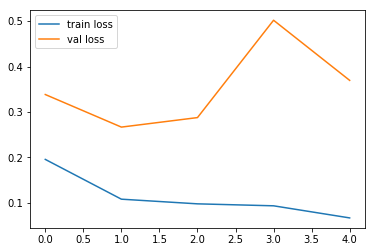

<Figure size 432x288 with 0 Axes>

In [27]:
# Plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

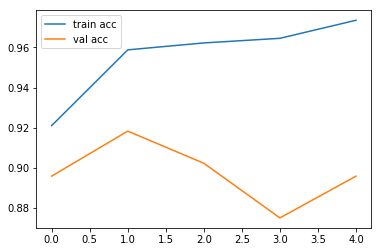

<Figure size 432x288 with 0 Axes>

In [28]:
# Plot the accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [0]:
# Save the model as a h5 file

import tensorflow as tf
from keras.models import load_model

model.save('model_vgg16.h5')

##Predicting Models

In [0]:
# Load the model
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
model = load_model('model_vgg16.h5')

In [35]:
!ls /content/chest_xray/val/PNEUMONIA | head -n 5

person1946_bacteria_4874.jpeg
person1946_bacteria_4875.jpeg
person1947_bacteria_4876.jpeg
person1949_bacteria_4880.jpeg
person1950_bacteria_4881.jpeg


In [36]:
!ls /content/chest_xray/val/NORMAL | head -n 5

NORMAL2-IM-1427-0001.jpeg
NORMAL2-IM-1430-0001.jpeg
NORMAL2-IM-1431-0001.jpeg
NORMAL2-IM-1436-0001.jpeg
NORMAL2-IM-1437-0001.jpeg


In [33]:
# Load image for prediction
img_path = val_path + 'PNEUMONIA/person1946_bacteria_4874.jpeg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
classes

array([[0., 1.]], dtype=float32)

In [0]:
# Similary you can use the same template for Vgg 19, Resnet50, Mobilenet. All you have to import the library. Below are the examples

from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3